In [26]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
from dotenv import load_dotenv
from scipy.ndimage import find_objects
load_dotenv()

True

In [89]:
data = Path(os.getenv('DATA'))/'nako'
#h5_path = data/'interim/t1_pp_15_stripped.h5' 
h5_path = data/'interim/t1_pp_10_stripped.h5'
h5_path_cropped = h5_path.parent/h5_path.name.replace('stripped', 'cropped')

In [90]:
# get bounding boxes
box = []
with h5py.File(h5_path, 'r') as hf:
    print(list(hf))
    keys = list(hf['image'])
    for k in tqdm(keys):
        mask = hf['mask_brain'][k][:].astype(np.uint8)
        box.append(find_objects(mask)[0])

['image', 'mask_brain']


In [91]:
# original shape
print(mask.shape)

(182, 218, 182)


In [92]:
print('start')
for k in range(3):
    s = np.percentile([box[n][k].start for n in range(len(box))], 10)
    print(f'{k}: {s}')

print('stop')
for k in range(3):
    s = np.percentile([box[n][k].stop for n in range(len(box))], 90)
    print(f'{k}: {s}')

start
0: 17.0
1: 16.0
2: 1.0
stop
0: 168.0
1: 202.0
2: 156.0


In [93]:
# cropped shape
#crop_box = (slice(10,110), slice(10,135), slice(0,105)) # data/'interim/t1_pp_15_stripped.h5' original shape (122, 146, 122)
crop_box = (slice(15,170), slice(15,200), slice(0,155)) # data/'interim/t1_pp_10_stripped.h5' original shape (182, 218, 182)

In [94]:
# save cropped images
with h5py.File(h5_path, 'r') as hf:
    with h5py.File(h5_path_cropped, 'w') as hf_cropped:
        gr_img_cropped = hf_cropped.require_group('image')
        gr_mask_cropped = hf_cropped.require_group('mask_brain')
        keys = list(hf['image'])
        for k in tqdm(keys):
            affine = np.array(hf['image'][k].attrs['affine'])
            mask = hf['mask_brain'][k][:].astype(np.uint8)
            img =  hf['image'][k][:].astype(np.float16)
            # crop to crop_box
            cropped_affine = np.copy(affine)
            cropped_affine[:, 3] = affine @ [crop_box[0].start, crop_box[1].start, crop_box[2].start, 1]
            cropped_mask = mask[crop_box]
            cropped_img = img[crop_box]
            # save in hdf5
            ds = gr_img_cropped.require_dataset(k, cropped_img.shape, dtype=cropped_img.dtype)
            ds[:] = cropped_img
            ds.attrs['affine'] = cropped_affine
            ds = gr_mask_cropped.require_dataset(k, cropped_mask.shape, dtype=cropped_mask.dtype)
            ds[:] = cropped_mask
            ds.attrs['affine'] = cropped_affine

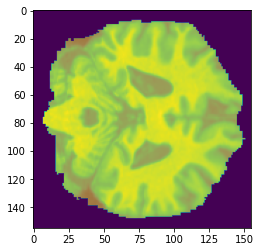

In [96]:
with h5py.File(h5_path_cropped, 'r') as hf_cropped:
    key = keys[0]
    cropped_img = hf_cropped['image'][key]
    cropped_mask = hf_cropped['mask_brain'][key]
    plt.imshow(cropped_img[:,70,:].astype(np.float32))
    plt.imshow(cropped_mask[:,70,:].astype(np.uint8), alpha=0.5)